In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf


In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available: 1


## Filtering through Data


In [ ]:
# import os

# train_folder = "/content/drive/MyDrive/plants_classifer/train"
# subfolders = [f.name for f in os.scandir(train_folder) if f.is_dir()]
# print("Subfolders:", subfolders)


from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/MyDrive/plants_classifier/train

Mounted at /content/drive
'Apple leaf'		    'Potato leaf late blight'
'Apple rust leaf'	    'Raspberry leaf'
'Apple Scab Leaf'	    'Soyabean leaf'
'Bell_pepper leaf'	    'Squash Powdery mildew leaf'
'Bell_pepper leaf spot'     'Strawberry leaf'
'Blueberry leaf'	    'Tomato Early blight leaf'
'Cherry leaf'		    'Tomato leaf'
'Corn Gray leaf spot'	    'Tomato leaf bacterial spot'
'Corn leaf blight'	    'Tomato leaf late blight'
'Corn rust leaf'	    'Tomato leaf mosaic virus'
'grape leaf'		    'Tomato leaf yellow virus'
'grape leaf black rot'	    'Tomato mold leaf'
'Peach leaf'		    'Tomato Septoria leaf spot'
'Potato leaf early blight'  'Tomato two spotted spider mites leaf'


In [ ]:
#Reformatting file strucutre into plant class and disease class.
import os
import shutil
from pathlib import Path

def prepare_directories(orig_root, target_root, plants):
    """
    Creates two structures under target_root:
      1) plant_classification/{train,test}/{plant}/
      2) disease_classification/{plant}/{train,test}/{disease_folder}/
    Copies images from orig_root/train and orig_root/test accordingly.
    """
    for split in ["train", "test"]:
        orig_split = Path(orig_root) / split
        # plant_classification
        pc_base = Path(target_root) / "plant_classification" / split
        # disease_classification per plant
        for plant in plants:
            dc_base = Path(target_root) / "disease_classification" / plant / split
            pc_base.joinpath(plant).mkdir(parents=True, exist_ok=True)
            dc_base.mkdir(parents=True, exist_ok=True)

        # iterate disease-folders in original
        for folder in orig_split.iterdir():
            if not folder.is_dir():
                continue
            # match this folder to a target plant
            for plant in plants:
                if folder.name.lower().startswith(plant.lower()):
                    # copy all images to plant_classification/plant
                    dest_pc = pc_base / plant
                    for img in folder.iterdir():
                        shutil.copy(img, dest_pc / img.name)

                    # copy entire disease folder into disease_classification/plant/split
                    dest_dc = Path(target_root) / "disease_classification" / plant / split / folder.name
                    shutil.copytree(folder, dest_dc, dirs_exist_ok=True)
                    break

In [ ]:
!ls /content/drive/MyDrive/plants_classifier/



filtered_data  plants-classifier.ipynb	test  train


In [ ]:
#running code to separate it
orig_root = "/content/drive/MyDrive/plants_classifier"
target_root = "/content/drive/MyDrive/plants_classifier/filtered_data"
plants = ["Apple", "grape", "Bell_pepper", "Tomato"]
prepare_directories(orig_root, target_root, plants)

In [ ]:
#Define categories
plants = ["Apple", "grape", "Bell_pepper", "Tomato"]


In [ ]:
!ls /content/drive/MyDrive/plants_classifier/test


'Apple leaf'		    'Potato leaf late blight'
'Apple rust leaf'	    'Raspberry leaf'
'Apple Scab Leaf'	    'Soyabean leaf'
'Bell_pepper leaf'	    'Squash Powdery mildew leaf'
'Bell_pepper leaf spot'     'Strawberry leaf'
'Blueberry leaf'	    'Tomato Early blight leaf'
'Cherry leaf'		    'Tomato leaf'
'Corn Gray leaf spot'	    'Tomato leaf bacterial spot'
'Corn leaf blight'	    'Tomato leaf late blight'
'Corn rust leaf'	    'Tomato leaf mosaic virus'
'grape leaf'		    'Tomato leaf yellow virus'
'grape leaf black rot'	    'Tomato mold leaf'
'Peach leaf'		    'Tomato Septoria leaf spot'
'Potato leaf early blight'


In [ ]:
#Making the data set for tf
import tensorflow as tf

def make_datasets(base_dir, split, class_mode, img_size=(224,224), batch_size=32, val_split=None, seed=32):
    args = dict(
        directory=str(Path(base_dir) / split),
        image_size=img_size,
        batch_size=batch_size,
        label_mode=class_mode,
        seed=seed
    )
    if val_split and split == "train":
        args.update({'validation_split': val_split, 'subset': 'training'})
        ds_train = tf.keras.preprocessing.image_dataset_from_directory(**args)
        args['subset'] = 'validation'
        ds_val = tf.keras.preprocessing.image_dataset_from_directory(**args)
        return ds_train, ds_val
    else:
        ds = tf.keras.preprocessing.image_dataset_from_directory(**args)
        return ds



In [ ]:
# Plant classification datasets (split train->train+val)
#Split training data. 90% split for training. 10% goes to testing.
train_ds, val_ds = make_datasets(
    base_dir = "/content/drive/MyDrive/plants_classifier/filtered_data/plant_classification", split = "train", class_mode='int', val_split=0.1
)
test_ds = make_datasets(
    base_dir = "/content/drive/MyDrive/plants_classifier/filtered_data/plant_classification", split = "test", class_mode='int'
)

# For each plant, disease classification ds:
disease_ds = {}
for plant in plants:
    pdir = f"/content/drive/MyDrive/plants_classifier/filtered_data/disease_classification/{plant}"
    train_d, val_d = make_datasets(pdir, "train", class_mode='int', val_split=0.1)
    test_d = make_datasets(pdir, "test", class_mode='int')
    disease_ds[plant] = (train_d, val_d, test_d)

Found 1148 files belonging to 4 classes.
Using 1034 files for training.
Found 1148 files belonging to 4 classes.
Using 114 files for validation.
Found 135 files belonging to 4 classes.
Found 244 files belonging to 3 classes.
Using 220 files for training.
Found 244 files belonging to 3 classes.
Using 24 files for validation.
Found 29 files belonging to 3 classes.
Found 112 files belonging to 2 classes.
Using 101 files for training.
Found 112 files belonging to 2 classes.
Using 11 files for validation.
Found 20 files belonging to 2 classes.
Found 115 files belonging to 2 classes.
Using 104 files for training.
Found 115 files belonging to 2 classes.
Using 11 files for validation.
Found 17 files belonging to 2 classes.
Found 677 files belonging to 9 classes.
Using 610 files for training.
Found 677 files belonging to 9 classes.
Using 67 files for validation.
Found 69 files belonging to 8 classes.


Classes: ['Apple', 'Bell_pepper', 'Tomato', 'grape']


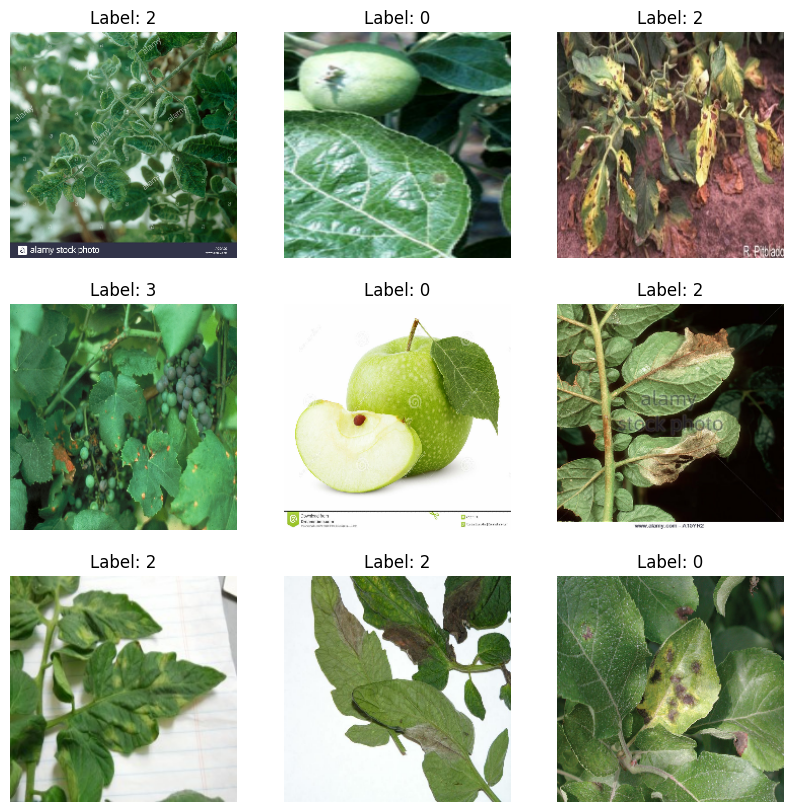

In [ ]:
# sanity check. checking length of files.

print("Classes:", train_ds.class_names)


# Show a few samples
import matplotlib.pyplot as plt

def show_batch(dataset):
    images, labels = next(iter(dataset))
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")

show_batch(train_ds)


In [ ]:
#looking through data
train_count = sum([len(b[0]) for b in train_ds])
val_count = sum([len(b[0]) for b in val_ds])
print(f"Train images: {train_count}, Validation images: {val_count}")


Train images: 1034, Validation images: 114


## Model 1: Classify Images into Crops
This model classifies the images into the four categories: apples, tomatoes, grapes, and bell peppers.

In [ ]:
#first training model. builds vgg16 model.
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

#used imagenet for parameters
def build_vgg_model(num_classes):
    base = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))
    base.trainable = False  # freeze
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=optimizers.Adam(1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model




In [ ]:
# Train Plant Type Classifier
#runnig the plant classifier. accuracy shown below.
plant_model = build_vgg_model(num_classes=len(plants))
plant_history = plant_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)
plant_model.save('/content/drive/MyDrive/plants_classifier/models/plant_type_classifier.keras')


Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 449ms/step - accuracy: 0.3634 - loss: 5.1281 - val_accuracy: 0.5877 - val_loss: 2.2821
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 402ms/step - accuracy: 0.5045 - loss: 3.6045 - val_accuracy: 0.6316 - val_loss: 1.7234
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 399ms/step - accuracy: 0.5404 - loss: 3.0100 - val_accuracy: 0.6579 - val_loss: 1.4968
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 395ms/step - accuracy: 0.5696 - loss: 2.3873 - val_accuracy: 0.6754 - val_loss: 1.3466
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 411ms/step - accuracy: 0.5920 - loss: 2.1305 - val_accuracy: 0.7193 - val_loss: 1.1818
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 394ms/step - accuracy: 0.6060 - loss: 1.8917 - val_accuracy: 0.7368 - val_loss: 1.1849
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 384ms/step - accuracy: 0.6671 - loss: 1.6438 - val_accuracy: 0.7193 - val_loss: 1.1006
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 396ms/step - accuracy: 0.6163 - loss: 1.7141 - val_accu

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/plants_classifier/models/plant_type_classifier.keras'

In [ ]:
#reload files
from google.colab import drive
drive.flush_and_unmount()
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/plants_classifier/

Mounted at /content/drive
filtered_data  plants-classifier.ipynb	test  train


In [ ]:
plant_model.save('/content/drive/MyDrive/plants_classifier/plant_type_classifier.keras')


## Diesease Prediction Models

In [ ]:
disease_models = {}
for plant in plants:
    tr, va, te = disease_ds[plant]
    num_cls = len(tr.class_names)
    m = build_vgg_model(num_classes=num_cls)
    print(f"Training disease model for {plant} with classes: {tr.class_names}")

    # Train the model
    hist = m.fit(tr, validation_data=va, epochs=8)

    # Save the model in the modern Keras format
    save_path = f"/content/drive/MyDrive/plants_classifier/models/{plant}_disease_classifier.keras"
    m.save(save_path)

    # Store the model, test dataset, and class names
    disease_models[plant] = (m, te, tr.class_names)


Training disease model for Apple with classes: ['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf']
Epoch 1/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.3921 - loss: 4.8544 - val_accuracy: 0.4167 - val_loss: 1.9315
Epoch 2/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 479ms/step - accuracy: 0.3576 - loss: 5.1843 - val_accuracy: 0.4583 - val_loss: 2.0368
Epoch 3/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 405ms/step - accuracy: 0.3997 - loss: 4.3747 - val_accuracy: 0.5000 - val_loss: 1.9843
Epoch 4/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 556ms/step - accuracy: 0.4311 - loss: 3.9474 - val_accuracy: 0.5000 - val_loss: 1.7376
Epoch 5/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 398ms/step - accuracy: 0.4481 - loss: 3.9019 - val_accuracy: 0.5000 - val_loss: 1.4897
Epoch 6/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 531ms/step - accuracy: 0.4963 - loss: 3.7256 - val_accuracy: 0.5417 - val_loss: 1.3121
Epoch 7/8
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 657ms/step - accuracy: 0.5167 - loss: 3.0827 - val_accuracy: 0.5833 - val_loss: 1.1938
Epoch 8/8
7/7 ━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/plants_classifier/models

Mounted at /content/drive
Apple_disease_classifier.keras	      plant_type_classifier.keras
Bell_pepper_disease_classifier.keras  Tomato_disease_classifier.keras
grape_disease_classifier.keras


In [ ]:
#plant plus disease. takes the weights and decides what it is.
import numpy as np
from tensorflow.keras.preprocessing import image

# Load saved models & metadata
plant_model = tf.keras.models.load_model('/content/drive/MyDrive/plants_classifier/models/plant_type_classifier.keras')
disease_models = {}
for plant in plants:
    m = tf.keras.models.load_model(f"/content/drive/MyDrive/plants_classifier/models/{plant}_disease_classifier.keras")
    _, _, class_names = disease_ds[plant]
    disease_models[plant] = (m, class_names)

def preprocess_img(path, img_size=(224,224)):
    img = image.load_img(path, target_size=img_size)
    arr = image.img_to_array(img) / 255.0
    return np.expand_dims(arr, 0)

def predict(path):
    x = preprocess_img(path)
    p = plant_model.predict(x)
    plant = plants[np.argmax(p)]
    m, cls_names = disease_models[plant]
    d = m.predict(x)
    disease = cls_names[np.argmax(d)]
    return plant, disease


In [ ]:
loss, acc = plant_model.evaluate(test_ds)
print(f"Plant Classifier Accuracy: {acc:.2%}")



5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 249ms/step - accuracy: 0.7556 - loss: 1.1181
Plant Classifier Accuracy: 74.07%


In [ ]:
for plant in disease_models:
    model, class_names = disease_models[plant]
    _, _, test_ds = disease_ds[plant]  # get the test set
    loss, acc = model.evaluate(test_ds)
    print(f"{plant} Disease Classifier Accuracy: {acc:.2%}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.3793 - loss: 2.4467
Apple Disease Classifier Accuracy: 37.93%
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.6500 - loss: 1.3964
grape Disease Classifier Accuracy: 65.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.5294 - loss: 2.0993
Bell_pepper Disease Classifier Accuracy: 52.94%


3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.2326 - loss: 3.5125
Tomato Disease Classifier Accuracy: 24.64%
